In [2]:
import networkx as nx
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name',
                    'landuse', 'width', 'est_width', 'junction', 'surface',
                    'traffic_signals', 'crossing', 'railway',
                    'highway=busway']

ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential|unclassified"]' #|busway

    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM
    G = ox.graph_from_address('Rotterdam, Netherlands', dist=8000, network_type='drive', simplify=True, custom_filter=cf)

    # default speeds
    hwy_speeds = {'motorway': 100,
                    'trunk': 100,
                    'primary': 80,
                    'secondary': 50,
                    'residential': 30,
                    'tertiary': 50,
                    #'busway':50,
                    'unclassified': 30}

    G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G, precision=1)

    return G

In [40]:
def save_graph(G):
    filepath=f"./graphs/Rotterdam.graph.graphml"
    # ox.save_graph_geopackage(G, filepath=filepath)
    ox.save_graphml(G,filepath)

In [41]:
def draw_edges(graph):
    edges_fugitive = []


    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [42]:
# city = ("")
# distance = 2400
#
G=generate_streetnetwork()
# save_graph(G, city, distance)
#
# print(len(G.nodes()))

# show_graph(city, distance)

In [43]:
save_graph(G)

In [44]:
def show_graph():
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 4.476405837074832, 51.92372167950828)  # bank
    #suspect_start2 = ox.nearest_nodes(G, 4.415995554283529, 51.89888293142451) #port dock

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('red')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/prelim_Rotterdam.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

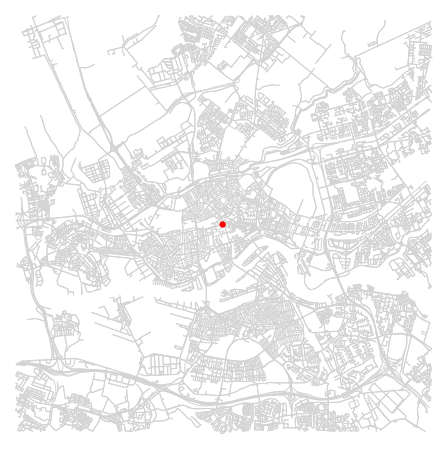

In [45]:
show_graph()

## Find border nodes

In [46]:
exit_nodes = []
for node in G.nodes():
    succ_nodes = [a for a in G.succ[node]]
    succ_nodes_type = [G.succ[node][b][0]['highway'] for b in succ_nodes]

    pred_nodes = [a for a in G.pred[node]]
    pred_nodes_type = [G.pred[node][b][0]['highway'] for b in pred_nodes]

    total_nodes_type = succ_nodes_type + pred_nodes_type
# check of er geen snelweg aanwezig is als de voorganger van een node
    if 'motorway' in total_nodes_type and any([x != 'motorway' or 'trunk' for x in pred_nodes_type]):
        exit_nodes.append(node)

len(exit_nodes)

150

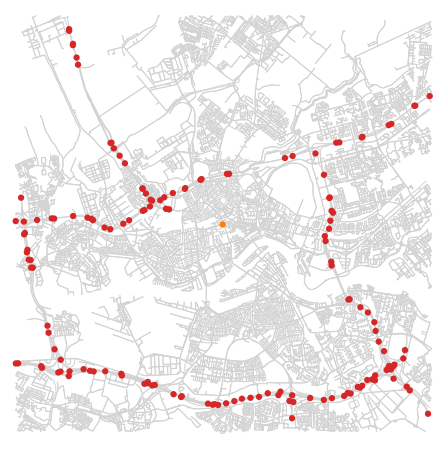

In [47]:
def show_graph(G):
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 4.476405837074832, 51.92372167950828)  # bank
    suspect_start2 = ox.nearest_nodes(G, 4.415995554283529, 51.89888293142451) #port dock

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in exit_nodes:
            node_size.append(40)
            node_color.append('tab:red')
#trunk nodes worden niet op de kaart getoond, zodat de exit nodes mooi op de Ring van Rotterdam liggen (dit is vanaf waar een fugitive is ontkomen of al gepakt moet zijn)
    #    elif node in trunk_nodes:
    #        node_size.append(40)
    #        node_color.append('tab:red')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'./graphs/Rotterdam.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

show_graph(G)

In [48]:
import pickle
#escape_nodes = list(set(exit_nodes).union(set(trunk_nodes)))
#escape_nodes liggen alleen op snelwegen
escape_nodes = list(set(exit_nodes))
with open('data/escape_nodes_Rotterdam.pkl', 'wb') as f:
    pickle.dump(escape_nodes, f)

# suspect_start = ox.nearest_nodes(G, 4.476405837074832, 51.92372167950828)  # bank
# suspect_start2 = ox.nearest_nodes(G, 4.415995554283529, 51.89888293142451) #port dock
# with open('data/fugitive_start_Rotterdam.pkl', 'wb') as f:
#     pickle.dump(suspect_start, f)

locations = {
    "centre": (4.476405837074832, 51.92372167950828),
    "port": (4.415995554283529, 51.89888293142451)
}

for location_name, coords in locations.items():
    suspect_start = ox.nearest_nodes(G, coords[0], coords[1])
    with open(f'data/fugitive_start_Rotterdam_{location_name}.pkl', 'wb') as f:
        pickle.dump(suspect_start, f)

In [49]:
import geopandas as gpd
import shapely

filepath=f"graphs/Rotterdam.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [50]:
nodes_gdf, streets = ox.graph_to_gdfs(G, nodes=True, edges=True,
                            node_geometry=False, fill_edge_geometry=True)
streets = streets.to_crs(4326)
streets

osmid  \
u           v           key                                                      
26673101    44255519    0                                              7326213   
26911590    44412339    0                                              7521379   
            44409291    0                                              7523166   
            44408715    0                                              7523171   
29335572    44265387    0                                              7326088   
...                                                                        ...   
11950837556 11950837548 0                             [1288790674, 1288790685]   
11950852451 44388914    0                                           1288790638   
11950855397 44379381    0                                              7311904   
            44385460    0                             [1288790661, 1288790646]   
11986129487 44481127    0    [660953036, 7311829, 7311802, 96218011, 96218014]   

                                             name  \
u           v           key                         
26673101    44255519    0           Streijenhagen   
26911590    44412339    0          Achterklooster   
            44409291    0               Kipstraat   
            44408715    0            Mariniershof   
29335572    44265387    0           Frambozentuin   
...                                           ...   
11950837556 11950837548 0       Van Beethovenlaan   
11950852451 44388914    0       Tsjaikovskistraat   
11950855397 44379381    0       Van Beethovenlaan   
            44385460    0       Van Beethovenlaan   
11986129487 44481127    0    Prins Constantijnweg   

                                                 highway  maxspeed  \
u           v           key                                          
26673101    44255519    0                    residential        30   
26911590    44412339    0                    residential        30   
            44409291    0                    residential        30   
            44408715    0                    residential        30   
29335572    44265387    0                    residential        30   
...                                                  ...       ...   
11950837556 11950837548 0                       tertiary        50   
11950852451 44388914    0                    residential       NaN   
11950855397 44379381    0                    residential        50   
            44385460    0                    residential        50   
11986129487 44481127    0    [residential, unclassified]  [30, 50]   

                                              surface  oneway   length  \
u           v           key                                              
26673101    44255519    0               paving_stones   False   62.725   
26911590    44412339    0               paving_stones   False  115.110   
            44409291    0               paving_stones   False   28.554   
            44408715    0               paving_stones   False   97.694   
29335572    44265387    0               paving_stones   False   72.338   
...                                               ...     ...      ...   
11950837556 11950837548 0                     asphalt    True   30.596   
11950852451 44388914    0               paving_stones   False   13.413   
11950855397 44379381    0                         NaN   False  157.348   
            44385460    0                         NaN    True   34.675   
11986129487 44481127    0    [paving_stones, asphalt]   False  220.276   

                                                                      geometry  \
u           v           key                                                      
26673101    44255519    0    LINESTRING (4.55610 51.88856, 4.55602 51.88875...   
26911590    44412339    0      LINESTRING (4.49196 51.92262, 4.49348 51.92306)   
            44409291    0      LINESTRING (4.49196 51.92262, 4.49214 51.92239)   
            44408715    0      L

In [51]:
# import geopackage file in geopandas
nld = gpd.read_file("geodata/Rotterdam.geojson", layer=0)
# nld = gpd.read_file("graphs/FLEE/Netherlands_shapefile/nl_1km.shp")
nld = nld.to_crs(4326)
nld

,geometry
0,"POLYGON ((4.59339 51.99380, 4.58258 51.98771, ..."


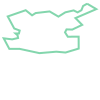

In [52]:
#de getekende grenzen van Rotterdam laten zien
multiLines = shapely.geometry.MultiLineString([x.exterior for x in nld.geometry])
multiLines

In [53]:
lines = streets.geometry.unary_union
intersection = lines.intersection(nld.geometry[0])
# [p for p in intersection.geoms]
type(intersection)

shapely.geometry.multilinestring.MultiLineString

In [54]:
#deze is al gejoined dus hoeft niet elke keer gerund te worden
intersectionn = gpd.sjoin(streets, nld)

<AxesSubplot:>

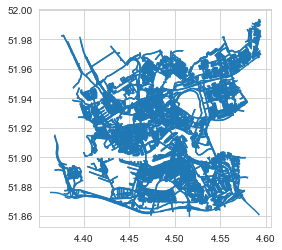

In [55]:
intersectionn.plot()

In [56]:
intersectionn

osmid  \
u           v          key                                                      
26673101    44255519   0                                              7326213   
26911590    44412339   0                                              7521379   
            44409291   0                                              7523166   
            44408715   0                                              7523171   
29335572    44265387   0                                              7326088   
...                                                                       ...   
11891670302 44600881   0                                              7316857   
11891700060 4800854862 0                                           1021664476   
            44191646   0                                            468346009   
11898465943 44330132   0                                              7518535   
11986129487 44481127   0    [660953036, 7311829, 7311802, 96218011, 96218014]   

                                            name                      highway  \
u           v          key                                                      
26673101    44255519   0           Streijenhagen                  residential   
26911590    44412339   0          Achterklooster                  residential   
            44409291   0               Kipstraat                  residential   
            44408715   0            Mariniershof                  residential   
29335572    44265387   0           Frambozentuin                  residential   
...                                          ...                          ...   
11891670302 44600881   0              Dennekruid                  residential   
11891700060 4800854862 0                     NaN                 unclassified   
            44191646   0               Korperweg                    secondary   
11898465943 44330132   0                     NaN                 unclassified   
11986129487 44481127   0    Prins Constantijnweg  [residential, unclassified]   

                            maxspeed                   surface  oneway  \
u           v          key                                               
26673101    44255519   0          30             paving_stones   False   
26911590    44412339   0          30             paving_stones   False   
            44409291   0          30             paving_stones   False   
            44408715   0          30             paving_stones   False   
29335572    44265387   0          30             paving_stones   False   
...                              ...                       ...     ...   
11891670302 44600881   0          30             paving_stones   False   
11891700060 4800854862 0          50                       NaN   False   
            44191646   0          50                       NaN    True   
11898465943 44330132   0         NaN                       NaN   False   
11986129487 44481127   0    [30, 50]  [paving_stones, asphalt]   False   

                             length  \
u           v          key            
26673101    44255519   0     62.725   
26911590    44412339   0    115.110   
            44409291   0     28.554   
            44408715   0     97.694   
29335572    44265387   0     72.338   
...                             ...   
11891670302 44600881   0     17.950   
11891700060 4800854862 0      7.271   
            44191646   0     90.825   
11898465943 44330132   0    169.502   
11986129487 44481127   0    220.276   

                                                                     geometry  \
u           v          key                                                      
26673101    44255519   0    LINESTRING (4.55610 51.88856, 4.55602 51.88875...   
26911590    44412339   0      LINESTRING (4.49196 51.92262, 4.49348 51.92306)   
            44409291   0      LINESTRING (4.49196 51.92262, 4.49214 51.92239)   
            44408715   0      LINESTRING (4.49196 51.92262, 4.49063 51.92231)   
2933557

In [57]:
unique_osmids_u = list(intersectionn.index.unique(level=0))
unique_osmids_v = list(intersectionn.index.unique(level=1))
unique_osmids = list(set(unique_osmids_u) | set(unique_osmids_v))
# nodes_gdf.iloc[unique_osmids]
nodes_gdf_intersection = nodes_gdf[nodes_gdf.index.isin(unique_osmids)]

In [58]:
len(unique_osmids)

11548

In [59]:
nodes_gdf_intersection

,y,x,street_count,highway,ref
osmid,,,,,
26673101,51.888562,4.556098,1,NaN,NaN
26911590,51.922623,4.491962,3,NaN,NaN
29335572,51.890354,4.556670,1,NaN,NaN
29335597,51.889970,4.554568,1,NaN,NaN
29335612,51.889823,4.553497,1,NaN,NaN
...,...,...,...,...,...
11871748831,51.933189,4.481505,1,NaN,NaN
11891670302,51.959686,4.553719,1,NaN,NaN
11891700060,51.877138,4.455535,3,NaN,NaN


In [60]:
G_intersection = ox.graph_from_gdfs(nodes_gdf_intersection, intersectionn)

In [61]:
len(G_intersection.nodes())

11548

In [62]:
save_graph(G_intersection)

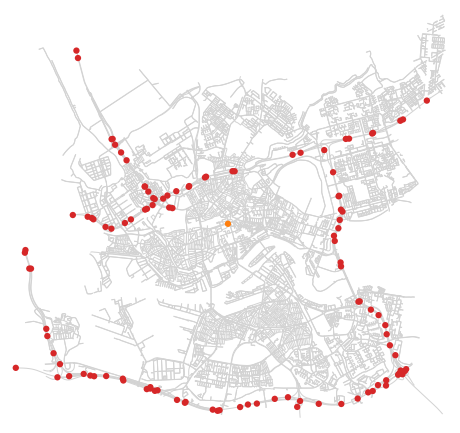

In [63]:
show_graph(G=G_intersection)

## Cameras

In [64]:
cameras_df= pd.read_excel(f'./data/cameras_rotterdam.xlsx')
cameras_df
len(cameras_df)

76

In [65]:
#delete the cameras that are outside the bounding box
for index, row in cameras_df.iterrows():
    if row['Latitude'] < 51.863171 or row['Latitude'] > 51.970486 :
        df_fixed = cameras_df.drop(index)
    elif row['Longitude'] < 4.427773  or row['Longitude'] > 4.580918:
        cameras_df = cameras_df.drop(index)

In [66]:
len(cameras_df)

40

In [67]:
cameras = []
for index, row in cameras_df.iterrows():
   # if row['Soort'] != 'ANPR-camera':
    #    continue

    lat = float(row['Latitude'])
    lon = float(row['Longitude'])
    closest_node = ox.nearest_nodes(G, lon, lat)
    cameras.append(closest_node)

cameras = list(set(cameras))
cameras

[767586561,
 44335490,
 4524908035,
 1435580676,
 44283909,
 44122119,
 44549386,
 1578634250,
 44310675,
 735629205,
 44179482,
 5349563812,
 680202405,
 1680185385,
 44294838,
 44176183,
 614678456,
 2771083713,
 670854722,
 44529099,
 4800854862,
 44598224,
 1402734930,
 1680069844,
 44545750,
 307156957,
 44548838,
 44291181,
 44349037,
 44355197]

In [68]:
with open(f'./data/cameras_Rotterdam.pkl', 'wb') as f:
    pickle.dump(cameras, f)

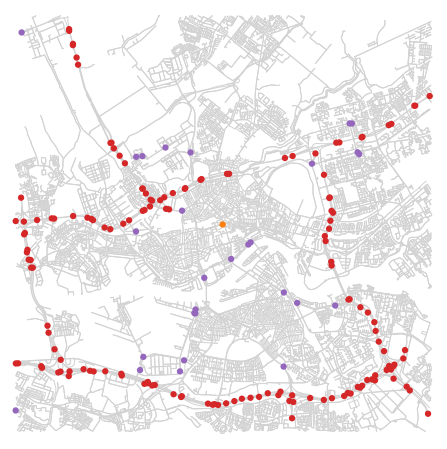

In [69]:
def show_graph(G, escape_nodes, cameras):
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 4.476405837074832, 51.92372167950828)  # bank

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in cameras:
            node_size.append(40)
            node_color.append('tab:purple')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'./graphs/Rotterdam.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

show_graph(G, escape_nodes, cameras)

Printen en verwerken van resultaten:

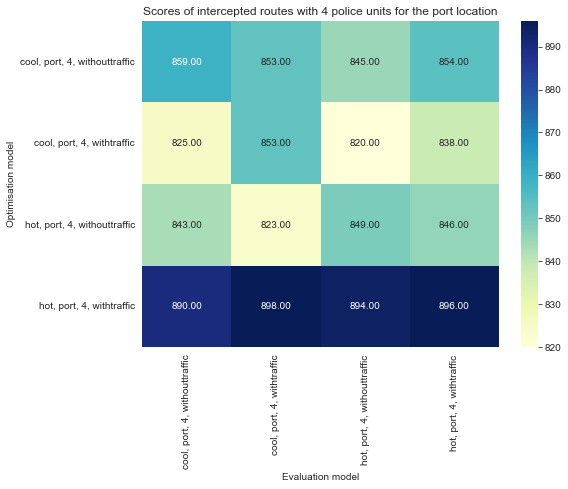

In [24]:
import pickle
import seaborn as sns
with open(f'./results/optimization/scores_Rotterdam_port_4.pkl', 'rb') as f:
    scores = pickle.load(f)

x_labels = ['cool, port, 4, withouttraffic', 'cool, port, 4, withtraffic', 'hot, port, 4, withouttraffic', 'hot, port, 4, withtraffic']
y_labels = ['cool, port, 4, withouttraffic', 'cool, port, 4, withtraffic', 'hot, port, 4, withouttraffic', 'hot, port, 4, withtraffic']

plt.figure(figsize=(8, 6))

sns.heatmap(scores, vmax=896, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels)

plt.title('Scores of intercepted routes with 4 police units for the port location')
plt.xlabel('Evaluation model')
plt.ylabel('Optimisation model')

plt.show()

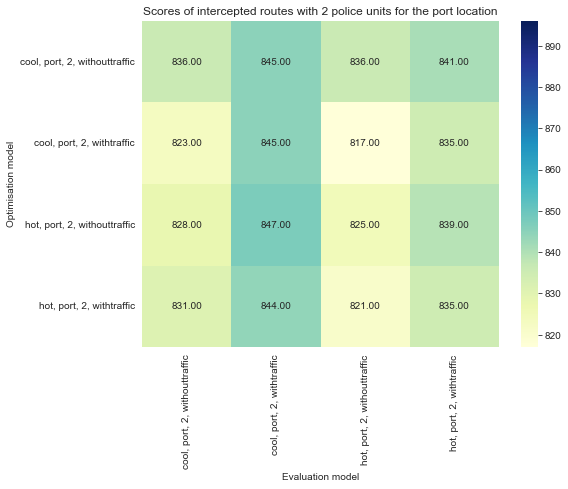

In [25]:

with open(f'./results/optimization/scores_Rotterdam_port_2.pkl', 'rb') as f:
    scores = pickle.load(f)

x_labels = ['cool, port, 2, withouttraffic', 'cool, port, 2, withtraffic', 'hot, port, 2, withouttraffic', 'hot, port, 2, withtraffic']
y_labels = ['cool, port, 2, withouttraffic', 'cool, port, 2, withtraffic', 'hot, port, 2, withouttraffic', 'hot, port, 2, withtraffic']

plt.figure(figsize=(8, 6))

sns.heatmap(scores, vmax=896, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels)

plt.title('Scores of intercepted routes with 2 police units for the port location')
plt.xlabel('Evaluation model')
plt.ylabel('Optimisation model')

# Toon de heatmap in de notebook
plt.show()

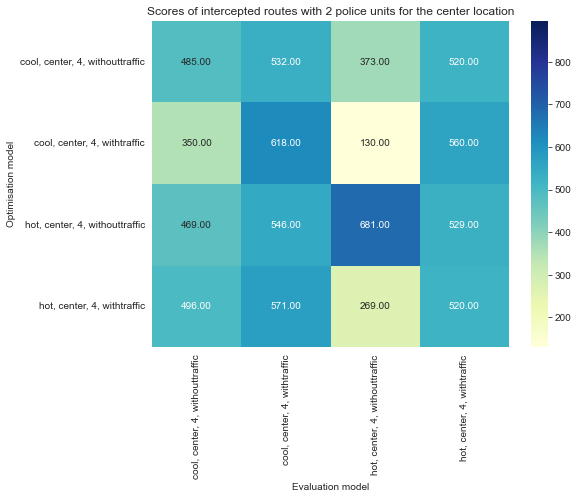

In [26]:

with open(f'./results/optimization/scores_Rotterdam_centre_4.pkl', 'rb') as f:
    scores = pickle.load(f)

x_labels = ['cool, center, 4, withouttraffic', 'cool, center, 4, withtraffic', 'hot, center, 4, withouttraffic', 'hot, center, 4, withtraffic']
y_labels = ['cool, center, 4, withouttraffic', 'cool, center, 4, withtraffic', 'hot, center, 4, withouttraffic', 'hot, center, 4, withtraffic']

plt.figure(figsize=(8, 6))

sns.heatmap(scores, vmax=896, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels)

plt.title('Scores of intercepted routes with 2 police units for the center location')
plt.xlabel('Evaluation model')
plt.ylabel('Optimisation model')

# Toon de heatmap in de notebook
plt.show()

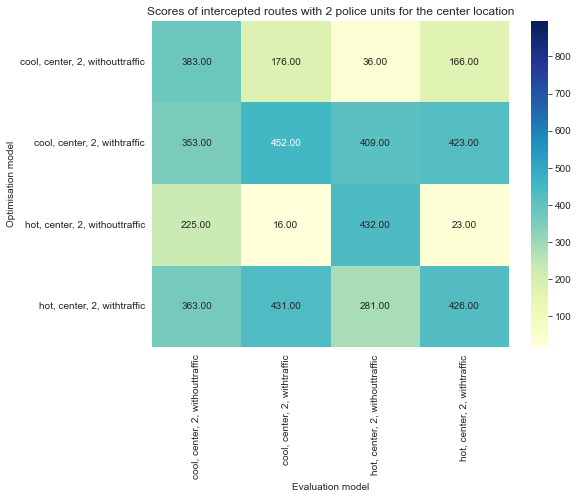

In [27]:
with open(f'./results/optimization/scores_Rotterdam_centre_2.pkl', 'rb') as f:
    scores = pickle.load(f)

x_labels = ['cool, center, 2, withouttraffic', 'cool, center, 2, withtraffic', 'hot, center, 2, withouttraffic', 'hot, center, 2, withtraffic']
y_labels = ['cool, center, 2, withouttraffic', 'cool, center, 2, withtraffic', 'hot, center, 2, withouttraffic', 'hot, center, 2, withtraffic']

plt.figure(figsize=(8, 6))

sns.heatmap(scores, vmax=896, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=x_labels, yticklabels=y_labels)

plt.title('Scores of intercepted routes with 2 police units for the center location')
plt.xlabel('Evaluation model')
plt.ylabel('Optimisation model')

plt.show()

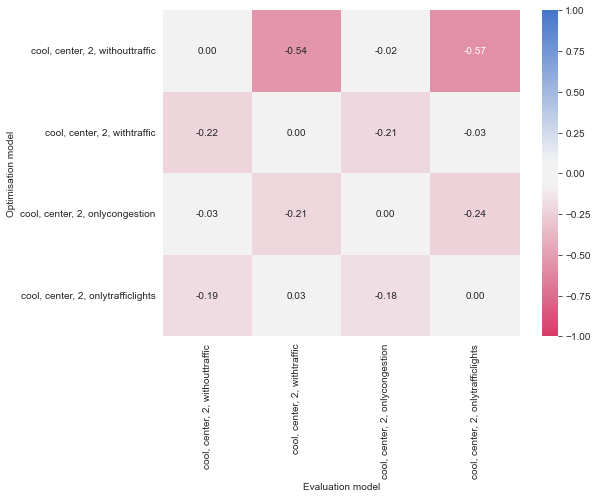

In [34]:

with open(f'./results/optimization/normalisedscores_Rotterdam_centre_4_traffic.pkl', 'rb') as f:
    scores = pickle.load(f)

x_labels = ['cool, center, 4, withouttraffic', 'cool, center, 4, withtraffic', 'cool, center, 4, onlycongestion', 'cool, center, 4, onlytrafficlights']
y_labels = ['cool, center, 4, withouttraffic', 'cool, center, 4, withtraffic', 'cool, center, 4, onlycongestion', 'cool, center, 4, onlytrafficlights']

plt.figure(figsize=(8, 6))

cmap = sns.diverging_palette(0, 255, sep=20, as_cmap=True)
sns.heatmap(scores, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt=".2f", xticklabels=x_labels, yticklabels=y_labels)

#plt.title('Scores of intercepted routes with 2 police units for the center location for different traffic implemented')
plt.xlabel('Evaluation model')
plt.ylabel('Optimisation model')

plt.show()